In [69]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Xử lí dữ liệu

In [70]:
# Tải dữ liệu lịch sử của cổ phiếu (ví dụ: 'AAPL' cho Apple)
ticker = 'AAPL'
data = yf.download(ticker, start="2020-01-01", end="2024-05-01")

# Tính giá trung bình
data['Price'] = data[['Open', 'Close', 'High', 'Low']].mean(axis=1)

# Chọn các cột cần thiết
data = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Price']]

# Kiểm tra giá trị bị thiếu
print(data.isna().sum())

# Xử lý giá trị bị thiếu (loại bỏ các hàng có giá trị bị thiếu)
data.dropna(inplace=True)

# Lưu dữ liệu vào tệp CSV
csv_file = f'{ticker}_historical_data.csv'
data.to_csv(csv_file)
print(f"Dữ liệu đã được lưu vào tệp {csv_file}")

# Đọc dữ liệu từ tệp CSV (Tuỳ chọn)
data_from_csv = pd.read_csv(csv_file, index_col=0)
print(data_from_csv.head())

# Chuẩn bị dữ liệu cho mô hình
prices = data_from_csv['Price'].values
volumes = data_from_csv['Volume'].values

# Căn chỉnh dữ liệu
volumes = volumes[1:]  # Loại bỏ phần tử đầu tiên của volumes
prices = prices[:-1]   # Loại bỏ phần tử cuối cùng của prices

# Số lượng mẫu
m = len(volumes)

[*********************100%%**********************]  1 of 1 completed


AttributeError: 'list' object has no attribute 'isna'

Gradient Descent

In [ ]:
# Khởi tạo tham số
b = 0
a = 0
alpha = 0.000001  # Learning rate
epochs = 10000  # Số lần lặp

# Gradient Descent
for epoch in range(epochs):
    volume_pred = b + a * prices
    error = volume_pred - volumes
    db = (1/m) * np.sum(error)
    da = (1/m) * np.sum(error * prices)
    
    # Kiểm tra các giá trị không hợp lệ trước khi cập nhật
    if not np.isnan(db) and not np.isnan(da):
        b -= alpha * db
        a -= alpha * da
    else:
        print(f"Encountered NaN at epoch {epoch}")
        break

print(f"Hệ số b: {b}, hệ số a: {a}")


Hệ số b: 131445.8872286415, hệ số a: 578713.320744188


Dự đoán

In [ ]:
# Dự đoán volume sử dụng các hệ số vừa tìm được
volume_pred = b + a * prices

Tính toán

In [ ]:
# Tính tổng bình phương của các phần dư (SSR)
ssr = np.sum((volume_pred - volumes) ** 2)
print(f"Tổng bình phương của các phần dư (SSR): {ssr}")

Tổng bình phương của các phần dư (SSR): 5.186439071952834e+18


Tổng bình phương của các phần dư (SSR) với sklearn: 1.7753889198064906e+18
Hệ số hồi quy (intercept) với sklearn: 245849064.76384753
Hệ số hồi quy (slope) với sklearn: -1043618.1189253707


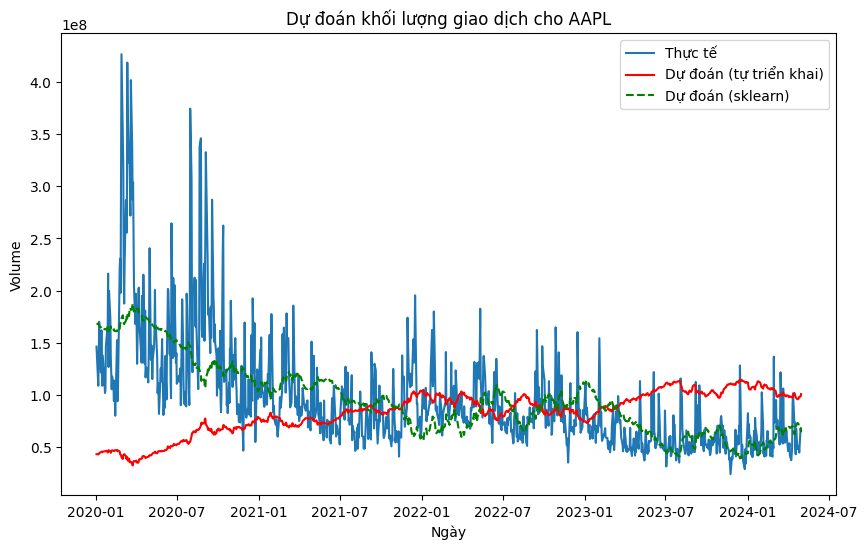

In [ ]:
# Sử dụng sklearn để so sánh
# Chuyển đổi prices thành dạng 2D cho sklearn
prices_reshaped = prices.reshape(-1, 1)

# Khởi tạo và huấn luyện mô hình LinearRegression của sklearn
model = LinearRegression()
model.fit(prices_reshaped, volumes)

# Dự đoán khối lượng giao dịch với sklearn
volumes_pred_sklearn = model.predict(prices_reshaped)

# Tính SSR cho mô hình sklearn
ssr_sklearn = mean_squared_error(volumes, volumes_pred_sklearn) * m
print(f"Tổng bình phương của các phần dư (SSR) với sklearn: {ssr_sklearn}")

# So sánh hệ số hồi quy
print(f"Hệ số hồi quy (intercept) với sklearn: {model.intercept_}")
print(f"Hệ số hồi quy (slope) với sklearn: {model.coef_[0]}")

# Vẽ biểu đồ so sánh
plt.figure(figsize=(10, 6))
plt.plot(data.index[1:], volumes, label='Thực tế')
plt.plot(data.index[1:], volume_pred, label='Dự đoán (tự triển khai)', color='r')
plt.plot(data.index[1:], volumes_pred_sklearn, label='Dự đoán (sklearn)', color='g', linestyle='--')
plt.xlabel('Ngày')
plt.ylabel('Volume')
plt.title(f'Dự đoán khối lượng giao dịch cho {ticker}')
plt.legend()
plt.show()

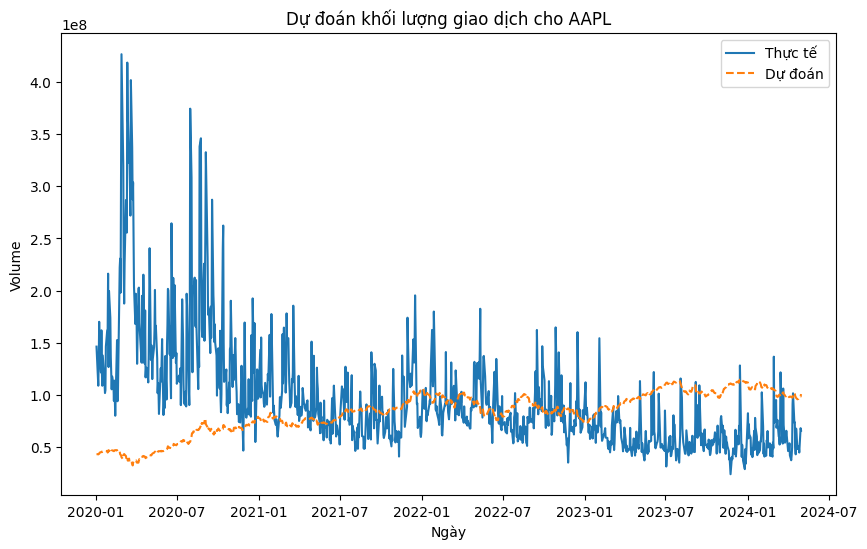

In [ ]:
# Đánh giá mô hình
# Vẽ biểu đồ so sánh
plt.figure(figsize=(10, 6))
plt.plot(data.index[1:], volumes, label='Thực tế')
plt.plot(data.index[1:], volume_pred, label='Dự đoán', linestyle='--')
plt.xlabel('Ngày')
plt.ylabel('Volume')
plt.title(f'Dự đoán khối lượng giao dịch cho {ticker}')
plt.legend()
plt.show()